## Projet Deep Learning : Reconnaissance d'images de pays
## **Modelisation**

#### Dataset:
Google Landmarks Dataset v2 :
https://github.com/cvdfoundation/google-landmark?tab=readme-ov-file


#### Objectif du projet :
<p style="text-align: justify;">
    L'objectif de ce projet est de développer une solution de Deep Learning pour la reconnaissance d'images. L'input sera une image d'un lieu, et la sortie du modèle sera le pays correspondant, accompagnée de probabilités d'appartenance.
</p>


In [26]:
from datetime import datetime
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import gdown
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torchvision.models as models

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
work_dir = "/content/drive/MyDrive/DEEP_LEARNING_PROJECT "
os.chdir(work_dir)
print("Répertoire actuel :", os.getcwd())

Répertoire actuel : /content/drive/.shortcut-targets-by-id/1Q-Loa1KiyiFY6-6XhlJ-BKwovS1l8OK6/DEEP_LEARNING_PROJECT 


In [29]:
DATA_TRAIN_PATH = "data"
DATA_RESULTS = "data"
MODELS = "models"

for path in [DATA_TRAIN_PATH, DATA_RESULTS, MODELS]:
    full_path = os.path.join(work_dir, path)
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Le dossier {full_path} n'existe pas. Crée-le ou vérifie le chemin.")
print("Tous les dossiers existent")


Tous les dossiers existent


In [7]:
!ls

 data			  models			 __pycache__
 download_dataset.ipynb   notebook_deepLearning.ipynb	 train_total_essaie.pt
 download-dataset.sh	 'Notes sur le projet DL.gdoc'
 inference.ipynb	  preprocessing.py


In [8]:
print("GPU disponible :", torch.cuda.is_available())

GPU disponible : True


### Importation des datasets

Importation d'un subset

In [30]:
DATA_TRAIN_PATH

'data'

In [44]:
train_dataset = torch.load(f"{DATA_TRAIN_PATH}/train_total_essaie.pt", weights_only=False)

In [11]:
print(type(train_dataset))
print(len(train_dataset))
print(train_dataset[0])

<class 'torch.utils.data.dataset.TensorDataset'>
100000
(tensor([[[[ 0.5536,  0.5536,  0.5707,  ...,  1.7865,  1.8037,  1.8208],
          [ 0.5193,  0.5193,  0.5364,  ...,  1.7865,  1.8037,  1.8208],
          [ 0.5193,  0.5193,  0.5364,  ...,  1.8037,  1.8037,  1.8208],
          ...,
          [-0.0287,  0.0741, -0.0116,  ..., -0.3198, -0.3541, -0.4397],
          [-0.0458,  0.0569,  0.0741,  ..., -0.4739, -0.4568, -0.3198],
          [ 0.1254,  0.0912, -0.0287,  ..., -0.6794, -0.6452, -0.5938]],

         [[ 0.7479,  0.7479,  0.7654,  ...,  1.9559,  1.9734,  1.9909],
          [ 0.7129,  0.7129,  0.7304,  ...,  1.9559,  1.9734,  1.9909],
          [ 0.7129,  0.7129,  0.7304,  ...,  1.9734,  1.9734,  1.9909],
          ...,
          [-0.0749,  0.0476, -0.0574,  ..., -0.3375, -0.3550, -0.4251],
          [-0.1975, -0.0399,  0.0126,  ..., -0.5126, -0.4776, -0.3025],
          [-0.0399, -0.0049, -0.1099,  ..., -0.7227, -0.6702, -0.5826]],

         [[ 1.2631,  1.2457,  1.2457,  ...,  

Import du labels mapping (etiquette pour chaque pays)

In [32]:
with open(f"{DATA_RESULTS}/country_labels_total_essaie.json", "r") as f:
    label_mapping = json.load(f)

In [33]:
label_mapping = {int(k): v for k, v in label_mapping.items()}

Train val test split

In [14]:
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Récupération des labels du train

In [15]:
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy().tolist())

In [16]:
print("Nombre total d'images dans train_loader:", len(all_labels))
print("Exemple de labels:", all_labels[:10])


Nombre total d'images dans train_loader: 80000
Exemple de labels: [107, 147, 58, 130, 131, 164, 128, 163, 56, 163]


In [17]:
for images, labels in train_loader:
    print("Batch de labels:", labels.numpy())
    break


Batch de labels: [163  14  70  56  56 130  77  61 163 163 127 147  60 128  40  10 164  77
 144 163  56 163 130 110 109  29 163 151  58 154  58 164]


In [18]:
from typing import Counter
# pip install Counter

In [34]:
label_counts = Counter(all_labels)
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=["Label", "Count"])
df_label_counts["Country"] = df_label_counts["Label"].map(label_mapping)
df_label_counts = df_label_counts.sort_values(by="Count", ascending=False)
print(df_label_counts.head())


    Label  Count         Country
5     164   9763   United States
7     163   8585  United Kingdom
2      58   8275         Germany
8      56   5848          France
11     77   4511           Italy


In [20]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = max(all_labels) + 1
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

Modèle EfficientNet

In [21]:
import torch.nn as nn
from torchvision import models

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier[1] = nn.Linear(
            self.efficientnet.classifier[1].in_features, num_classes
        )

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape
        x = x.squeeze(1)
        return self.efficientnet(x)

Initialisation du modèle, de la fonction de perte et de l'optimiseur

In [ ]:
model_ef = EfficientNetModel(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer_ef = optim.Adam(model_ef.parameters(), lr=LEARNING_RATE)

Fonctions train, evaluate

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Entrainement


100%|██████████| 2500/2500 [02:10<00:00, 19.11it/s]


Epoch [1/10]
Train Loss: 3.2164, Train Acc: 0.2119
Val Loss: 3.0283, Val Acc: 0.2482


100%|██████████| 2500/2500 [02:08<00:00, 19.46it/s]


Epoch [2/10]
Train Loss: 2.9534, Train Acc: 0.2616
Val Loss: 2.9400, Val Acc: 0.2741


100%|██████████| 2500/2500 [02:07<00:00, 19.57it/s]


Epoch [3/10]
Train Loss: 2.8013, Train Acc: 0.2893
Val Loss: 2.8347, Val Acc: 0.2904


100%|██████████| 2500/2500 [02:08<00:00, 19.52it/s]


Epoch [4/10]
Train Loss: 2.6636, Train Acc: 0.3186
Val Loss: 2.8005, Val Acc: 0.3040


100%|██████████| 2500/2500 [02:08<00:00, 19.48it/s]


Epoch [5/10]
Train Loss: 2.5155, Train Acc: 0.3462
Val Loss: 2.8003, Val Acc: 0.3044


100%|██████████| 2500/2500 [02:07<00:00, 19.54it/s]


Epoch [6/10]
Train Loss: 2.3707, Train Acc: 0.3759
Val Loss: 2.8075, Val Acc: 0.3041


100%|██████████| 2500/2500 [02:08<00:00, 19.49it/s]


Epoch [7/10]
Train Loss: 2.2077, Train Acc: 0.4087
Val Loss: 2.8428, Val Acc: 0.3085


100%|██████████| 2500/2500 [02:08<00:00, 19.39it/s]


Epoch [8/10]
Train Loss: 2.0420, Train Acc: 0.4460
Val Loss: 2.9405, Val Acc: 0.3023


100%|██████████| 2500/2500 [02:08<00:00, 19.52it/s]


Epoch [9/10]
Train Loss: 1.8632, Train Acc: 0.4855
Val Loss: 3.0082, Val Acc: 0.2958


100%|██████████| 2500/2500 [02:07<00:00, 19.55it/s]


Epoch [10/10]
Train Loss: 1.6887, Train Acc: 0.5253
Val Loss: 3.1240, Val Acc: 0.2957


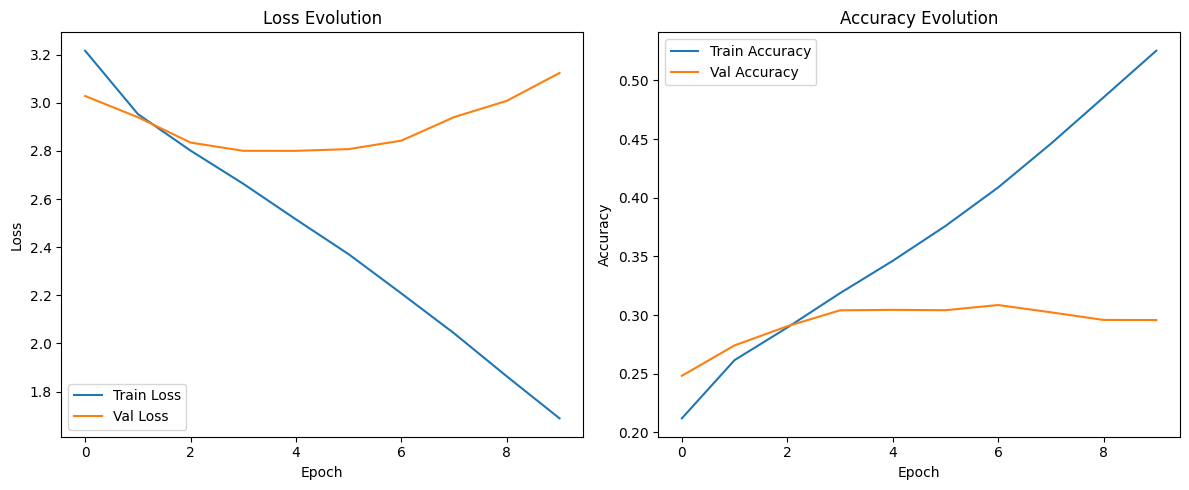

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model_ef , train_loader, criterion, optimizer_ef, DEVICE)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_loss, val_acc = evaluate(model_ef , val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

Sauvegarde du modèle

In [ ]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
name="model_ef"

torch.save(model_ef, f"{MODELS}/{name}_model_{time}.pth")
print(f"Modèle sauvegardé sous : {MODELS}/{name}_model_{time}.pth")

Modèle sauvegardé sous : models/model_ef_model_2025-04-16_12-05-34.pth


In [ ]:
def top_k_accuracy(output, target, k=5):
    topk_preds = output.topk(k, dim=1).indices
    correct = topk_preds.eq(target.view(-1, 1).expand_as(topk_preds))
    return correct.any(dim=1).float().mean().item()


In [ ]:
# #import du modele entrainé RESNET
# model = ResNet50Model(num_classes=NUM_CLASSES).to(DEVICE)
# checkpoint_path = f"{MODELS}/resnet50_model_2025-03-09_14-49-57.pth"
# model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))

In [ ]:
# #import du modele entrainé efficientnet
# model = EfficientNetModel(num_classes=NUM_CLASSES).to(DEVICE)

# checkpoint_path = f"{MODELS}/efficientnet_model_2025-03-09_14-55-06.pth"
# model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))


<ipython-input-34-7a1cf08080e4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))


<All keys matched successfully>

Evaluation des performances le dataset Test

In [ ]:
test_loss, test_acc = evaluate(model_ef, test_loader, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

all_predictions = []
all_true_labels = []

model_ef.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model_ef(images)
        _, predicted = outputs.max(1)

        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

class_report_txt = classification_report(all_true_labels, all_predictions, output_dict=False)
class_report_dict = classification_report(all_true_labels, all_predictions, output_dict=True)
print(class_report_txt)

Test Loss: 3.1387, Test Accuracy: 0.3000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           6       0.14      0.08      0.10        51
           7       0.46      0.51      0.49        35
           9       0.18      0.21      0.19       126
          10       0.27      0.07      0.11       180
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         0
          14       0.21      0.14      0.17        22
          15       0.00      0.00      0.00         2
          16       0.12      0.11      0.11        19
          17       0.24      0.15      0.19        73
          18       0.00      0.00      0.00         2
          20       0.00      0.00      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
df_report = pd.DataFrame(class_report_dict).T
df_report["country"] = df_report.index
df_report["country"] = df_report["country"].map(label_mapping)
df_report

,precision,recall,f1-score,support,country
0,0.000000,0.000000,0.000000,1.0,NaN
1,0.000000,0.000000,0.000000,3.0,NaN
2,0.000000,0.000000,0.000000,5.0,NaN
3,0.000000,0.000000,0.000000,1.0,NaN
4,0.000000,0.000000,0.000000,1.0,NaN
...,...,...,...,...,...
168,0.000000,0.000000,0.000000,5.0,NaN
169,0.000000,0.000000,0.000000,16.0,NaN
accuracy,0.300000,0.300000,0.300000,0.3,NaN
macro avg,0.124372,0.087959,0.095511,10000.0,NaN


## Test d'amélioration ajout d'un Early-Stopping

100%|██████████| 2500/2500 [02:02<00:00, 20.42it/s]


Epoch [1/50]
Train Loss: 3.1824, Train Acc: 0.2273
Val Loss: 2.8577, Val Acc: 0.2836


100%|██████████| 2500/2500 [02:01<00:00, 20.53it/s]


Epoch [2/50]
Train Loss: 2.7109, Train Acc: 0.3113
Val Loss: 2.6820, Val Acc: 0.3179


100%|██████████| 2500/2500 [02:01<00:00, 20.50it/s]


Epoch [3/50]
Train Loss: 2.4424, Train Acc: 0.3634
Val Loss: 2.5982, Val Acc: 0.3408


100%|██████████| 2500/2500 [02:02<00:00, 20.42it/s]


Epoch [4/50]
Train Loss: 2.2025, Train Acc: 0.4138
Val Loss: 2.6107, Val Acc: 0.3420


100%|██████████| 2500/2500 [02:03<00:00, 20.32it/s]


Epoch [5/50]
Train Loss: 1.9847, Train Acc: 0.4625
Val Loss: 2.6404, Val Acc: 0.3457


100%|██████████| 2500/2500 [02:02<00:00, 20.46it/s]


Epoch [6/50]
Train Loss: 1.7636, Train Acc: 0.5165
Val Loss: 2.7220, Val Acc: 0.3474


100%|██████████| 2500/2500 [02:02<00:00, 20.39it/s]


Epoch [7/50]
Train Loss: 1.5667, Train Acc: 0.5646
Val Loss: 2.8231, Val Acc: 0.3419


100%|██████████| 2500/2500 [02:01<00:00, 20.55it/s]


Epoch [8/50]
Train Loss: 1.3772, Train Acc: 0.6133
Val Loss: 2.9412, Val Acc: 0.3443
⏹️ Early stopping triggered!


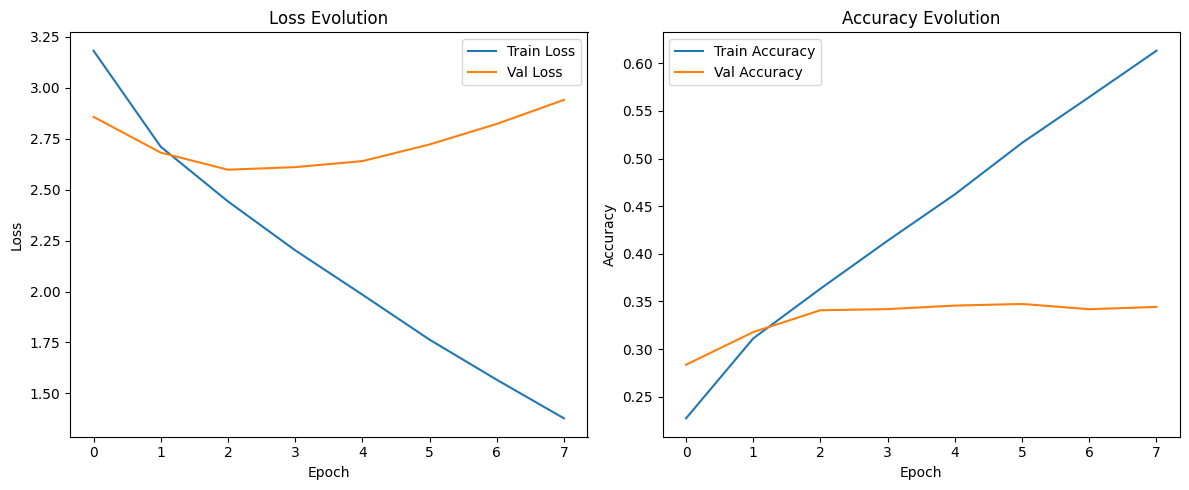

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier[1] = nn.Linear(
            self.efficientnet.classifier[1].in_features, num_classes
        )

    def forward(self, x):
        x = x.squeeze(1)
        return self.efficientnet(x)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

NUM_CLASSES = 172
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ef = EfficientNetModel(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer_ef = optim.Adam(model_ef.parameters(), lr=LEARNING_RATE)
early_stopper = EarlyStopping(patience=5)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model_ef, train_loader, criterion, optimizer_ef, DEVICE)
    val_loss, val_acc = evaluate(model_ef, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopper(val_loss, model_ef)

    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

model_ef.load_state_dict(early_stopper.best_model_state)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()


## Test d'amélioration: Autre modèle EfficientNet_B2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 223MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/20


100%|██████████| 2500/2500 [02:00<00:00, 20.80it/s]


Train Loss: 3.1781, Train Acc: 0.2301
Val Loss: 2.8454, Val Acc: 0.2845

Epoch 2/20


100%|██████████| 2500/2500 [01:59<00:00, 20.97it/s]


Train Loss: 2.7020, Train Acc: 0.3136
Val Loss: 2.6686, Val Acc: 0.3224

Epoch 3/20


100%|██████████| 2500/2500 [01:59<00:00, 20.97it/s]


Train Loss: 2.3949, Train Acc: 0.3775
Val Loss: 2.6255, Val Acc: 0.3391

Epoch 4/20


100%|██████████| 2500/2500 [01:59<00:00, 20.93it/s]


Train Loss: 2.1117, Train Acc: 0.4379
Val Loss: 2.6329, Val Acc: 0.3436

Epoch 5/20


100%|██████████| 2500/2500 [01:59<00:00, 20.91it/s]


Train Loss: 1.8369, Train Acc: 0.5020
Val Loss: 2.7248, Val Acc: 0.3420

Epoch 6/20


100%|██████████| 2500/2500 [01:58<00:00, 21.08it/s]


Train Loss: 1.5724, Train Acc: 0.5676
Val Loss: 2.8742, Val Acc: 0.3286

Epoch 7/20


100%|██████████| 2500/2500 [01:59<00:00, 20.91it/s]


Train Loss: 1.2340, Train Acc: 0.6575
Val Loss: 2.9569, Val Acc: 0.3347

Epoch 8/20


100%|██████████| 2500/2500 [01:59<00:00, 20.96it/s]


Train Loss: 1.0737, Train Acc: 0.6999
Val Loss: 3.1131, Val Acc: 0.3341
⏹️ Early stopping triggered!
💾 Modèle sauvegardé sous : models/efficientnet_b2_best_model_2025-04-17_18-22-24.pth


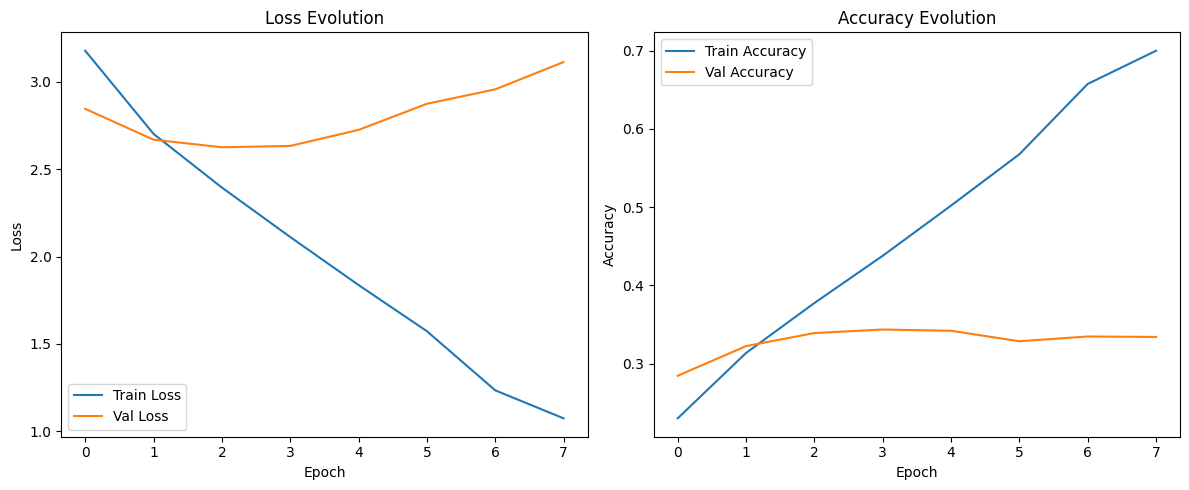

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from datetime import datetime

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.efficientnet = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier[0].p = 0.4
        self.efficientnet.classifier[1] = nn.Linear(
            self.efficientnet.classifier[1].in_features, num_classes
        )

    def forward(self, x):
        x = x.squeeze(1)
        return self.efficientnet(x)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

NUM_CLASSES = 172
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ef = EfficientNetModel(num_classes=NUM_CLASSES).to(DEVICE)

for param in model_ef.efficientnet.features[:4].parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer_ef = optim.Adam(model_ef.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ef, mode='min', factor=0.5, patience=2, verbose=True)
early_stopper = EarlyStopping(patience=5)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_epoch(model_ef, train_loader, criterion, optimizer_ef, DEVICE)
    val_loss, val_acc = evaluate(model_ef, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)
    early_stopper(val_loss, model_ef)

    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

model_ef.load_state_dict(early_stopper.best_model_state)

time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
name = "efficientnet_b2"
torch.save(model_ef, f"{MODELS}/{name}_best_model_{time}.pth")
print(f"Modèle sauvegardé sous : {MODELS}/{name}_best_model_{time}.pth")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()